# PyMem3DG Tutorial 1 - The Very Basic
`Cuncheng Zhu, Christopher T. Lee`

This tutorial provides a brief example for setting up a membrane simulation using PyMem3DG. The extensive documentations is hosted at https://rangamanilabucsd.github.io/Mem3DG/.

In [1]:
import pymem3dg as dg
import pymem3dg.boilerplate as dgb
from functools import partial
from pathlib import Path
import numpy as np

## Mesh initialization
PyMem3DG currently provide functions to generate simple meshes, as well as API to read $\texttt{.ply}$ files. For example, we could generate icosphere for closed membrane simualation and existing meshes based on parametrized ellipsoids. 

In [2]:
icoFace, icoVertex = dg.getIcosphere(1, 3)
#  could also do .getCylinder for example
oblate = "fixtures/sample_meshes/oblate.ply"
prolate = "../sample_meshes/prolate.ply"

## Instantiate the $\texttt{System}$:  $\texttt{Parameters}$ and  $\texttt{Options}$ 

Specification of the struct `Parameters` is largely user-defined. `Parameters` is the structured into sub-structs. For example, the parameters for bending of `Parameters p` is `p.bending`. Please refer to the documentation for detailed explanation of various entries. Below we shows the simulation setup for a homogeneous membrane undergoing osmotic shrinkage, which is a classic solution of the *shape equation* that results in the biconcave shape similar to the red blood cell. Because of the simplicity of the setup, we only specify essential physical quantities such as the bending rigidity, stretching modulus and bulk modulus, assuming the default  and omitting the majority of the parameters. 

The trajectory of the simulations will be solely determined by the initial condition (initial geometry) and parameters. In this tutorial, we will see how initial geometry affects the results.

In [3]:
geo = dg.Geometry(oblate)

0.7 * 3.14 * 4 / 3

2.9306666666666668

In [4]:
p = dg.Parameters()

p.bending.Kbc = 8.22e-5

p.tension.form = partial(
    dgb.preferredAreaSurfaceTensionModel, 
    modulus=0.1, 
    preferredArea=12.4866
    # area=12.4866
)
p.osmotic.form = partial(
    dgb.preferredVolumeOsmoticPressureModel,
    preferredVolume=0.7 * 3.14 * 4 / 3,
    # reservoirVolume=0,
    # volume=geo.getVolume(),
    strength=0.02,
)

# p.point = dgb.prescribeGaussianPointForce(
#     vertexPositions=geo.getVertexMatrix(), 
#     geodesicDistances=geo.computeGeodesicDistance(), 
#     Kf=0.23, 
#     std=2, 
#     tau=0.03, 
#     vertexDualAreas=[], 
#     time=0
# )


In [5]:
def serialize_parameters(p: dg.Parameters):
    import inspect
    param_data = {}
    for param_attr_name in dir(p):
        if not param_attr_name.startswith("__"):
            param_data[param_attr_name] = {}
            attr = getattr(p, param_attr_name)
            attr_props = {}
            for inner_name in dir(attr):
                if not inner_name.startswith("__"):
                    inner_attr = getattr(attr, inner_name)
                    excluded = ["function", "built-in"]
                    if not callable(inner_attr) or not inspect.isbuiltin(inner_attr):
                        attr_props[inner_name] = inner_attr
            param_data[param_attr_name] = attr_props

## Integration and optimization

PyMem3DG provides various evolvers to integrate the membrane dynamics or find mechanical/chemical equilibrium as the energy minimizer. Please refer to the documentation for details and guidelines. For simplicity, the forward euler method, mathematically equivalent to steepest descent method for optimization is used to integrate the three systems. The following integration is pre-runned. Uncomment `integrate()` to rerun them.

We first to integrate the oblate shape and we expect to form biconcave shape at the equilibrium. To visualize the result using polyscope, please refer to the documentation and a dedicated tutorial for visualization.


In [6]:
# geo = dg.Geometry(oblate)
start = geo.getVertexMatrix()

import shutil

outputDir = Path("out")
shutil.rmtree(outputDir)
outputDir.mkdir(parents=True, exist_ok=True)

g = dg.System(geometry=geo, parameters = p)
g.initialize()

In [9]:
!ls

MinE.txt       main.py        modelout.txt   test_processes
__init__.py    mem3dg_1.ipynb out            test_steps
fixtures       model.txt      test_notebooks


In [10]:
# geo = dg.Geometry(oblate)
start = geo.getVertexMatrix()

import shutil

outputDir = Path("out")
shutil.rmtree(outputDir)
outputDir.mkdir(parents=True, exist_ok=True)

g = dg.System(geometry=geo, parameters = p)
g.initialize()

fe = dg.Euler(system = g, 
              characteristicTimeStep = 200, 
              totalTime = 10000, 
              savePeriod = 100, 
              tolerance = 1e-11, 
              outputDirectory = str(outputDir))
# Uncomment to print intermediate statistics
# fe.ifPrintToConsole = True
fe.ifOutputTrajFile = True
success = fe.integrate() 
end = geo.getVertexMatrix()


Getting ahead, we can use Polycope (https://polyscope.run/py/) to visualize the trajectory. The detail will be provide in Tutorial 4. PyMem3DG provides a wrapper function to setup the visualization for inspecting the trajectory.

The below example is for purposes of easy illustration. We do not recommend running polyscope from within a jupyter notebook as it generates a separate window.

In [13]:
geo.getNotableVertex().reshape((162, 3))

ValueError: cannot reshape array of size 448 into shape (162,3)

In [10]:
from pymem3dg.visual import visualizeGeometry


visualizeGeometry(geo, True)

In [11]:
import pymem3dg.visual as dg_vis
import polyscope as ps
# # Uncomment the next two lines to run visualization
dg_vis.animate(str(outputDir / "traj.nc"), meanCurvature = True)
ps.show()

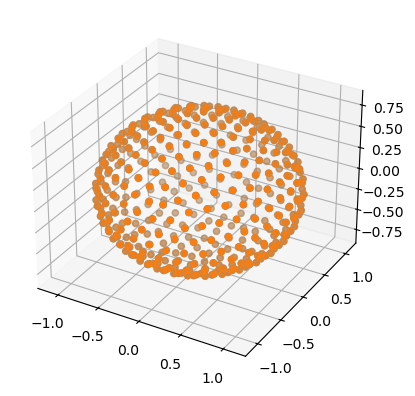

In [10]:
# plot the netcdf data in outputDir/"traj.nc" in matplotlib
import pymem3dg.visual as dg_vis
import matplotlib.pyplot as plt

from netCDF4 import Dataset

from bsp.utils.membrane_utils import get_vertex_coordinates, format_vertices
data = Dataset(str(outputDir / "traj.nc"),'r')

# get data parameters
variables = data.groups['Trajectory'].variables

# get the coordinates from groups/trajectory.variables
x = data.groups['Trajectory'].variables['coordinates'][:]

# plot x[] in 3d spaces
# where the array is xyz, xyz, xyz

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# this needs to be flattened
ax.scatter(x[0][::3], x[0][1::3], x[0][2::3])
ax.scatter(x[-1][::3], x[-1][1::3], x[-1][2::3])

plt.show()

ValueError: zero-size array to reduction operation minimum which has no identity

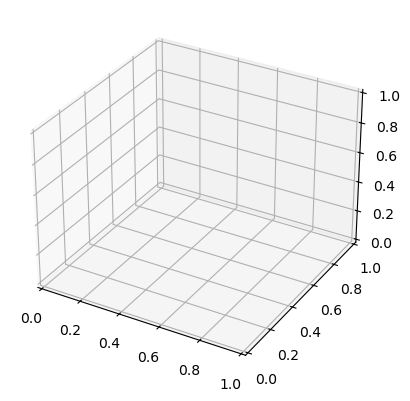

In [8]:
from bsp.utils.membrane_utils import get_animation
from IPython.display import HTML

ani = get_animation(x)

# Display animation in Jupyter Notebook
HTML(ani.to_jshtml())


In [36]:
np.array([x[-1][::3], x[-1][1::3], x[-1][2::3]]).shape

(3, 448)

In [11]:
dir(geo)



['__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'computeGeodesicDistance',
 'getCotanLaplacian',
 'getEdgeAdjacencyMatrix',
 'getEdgeLengths',
 'getFaceAreas',
 'getFaceMatrix',
 'getGeodesicDistance',
 'getLumpedMassMatrix',
 'getNotableVertex',
 'getPolyscopeEdgeOrientations',
 'getPolyscopePermutations',
 'getSurfaceArea',
 'getVertexAdjacencyMatrix',
 'getVertexDualAreas',
 'getVertexGaussianCurvatureVectors',
 'getVertexGaussianCurvatures',
 'getVertexMatrix',
 'getVertexMeanCurvatureVectors',
 'getVertexMeanCurvatures',
 'getVertexNormals',
 'getVertexSchlafliLaplacianMeanCurvatureVectors',
 'getVertexVolumeVariationVectors',
 'getVolume',
 'setInputVertexPositions']

In [15]:
geodesic = geo.computeGeodesicDistance()

pf = dgb.prescribeGaussianPointForce(vertexPositions=geo.getVertexMatrix(), geodesicDistances=geodesic, Kf=0.23, std=2, tau=0.03, vertexDualAreas=[], time=g.time)

/Users/alexanderpatrie/miniforge3/envs/bsp/lib/python3.10/site-packages/pymem3dg/util.py:91: RuntimeWarning: overflow encountered in square
  prob_density = np.exp(-0.5 * ((x - mean) / sd) ** 2) / (sd * (2 * np.pi) ** 0.5)


In [17]:
pf

array([[-0., -0., -0.],
       [-0., -0., -0.],
       [-0., -0., -0.],
       ...,
       [ 0.,  0.,  0.],
       [-0.,  0.,  0.],
       [ 0.,  0.,  0.]])

In [69]:
data.groups['Trajectory'].variables

{'time': <class 'netCDF4.Variable'>
 float64 time(frame)
     units:  seconds 
 path = /Trajectory
 unlimited dimensions: frame
 current shape = (102,)
 filling on, default _FillValue of 9.969209968386869e+36 used,
 'topology': <class 'netCDF4.Variable'>
 vlen topology(frame)
 vlen data type: uint32
 path = /Trajectory
 unlimited dimensions: frame
 current shape = (102,),
 'coordinates': <class 'netCDF4.Variable'>
 vlen coordinates(frame)
 vlen data type: float64
 path = /Trajectory
 unlimited dimensions: frame
 current shape = (102,),
 'refcoordinates': <class 'netCDF4.Variable'>
 vlen refcoordinates(frame)
 vlen data type: float64
 path = /Trajectory
 unlimited dimensions: frame
 current shape = (102,),
 'notablevertex': <class 'netCDF4.Variable'>
 vlen notablevertex(frame)
 vlen data type: int8
 path = /Trajectory
 unlimited dimensions: frame
 current shape = (102,),
 'proteindensity': <class 'netCDF4.Variable'>
 vlen proteindensity(frame)
 vlen data type: float64
 path = /Trajector

In [44]:
data.groups['Trajectory'].variables['velocities'][:][-1].shape

(1344,)

In [50]:
data.groups['Trajectory'].variables['proteindensity'][:][-1].shape

(448,)

In [61]:
import numpy as np

# Extract vertex positions (for a single timestep)
data.groups['Trajectory'].variables['coordinates'][:][0].shape  # Shape: (N*3,)



(1344,)

In [34]:
icoVertex.shape

(642, 3)

In [29]:
v = [1, 2, 3, 1, 2, 3]


<class 'netCDF4.Group'>
group /Trajectory:
    dimensions(sizes): frame(102)
    variables(dimensions): float64 time(frame), uint32 topology(frame), float64 coordinates(frame), float64 refcoordinates(frame), int8 notablevertex(frame), float64 proteindensity(frame), float64 velocities(frame), float64 externalForce(frame)
    groups: 

Similarly, we could have the same procedure with initial condition of prolate shape.

In [ ]:
outputDir = Path("output/tutorial1/dumbbell")
outputDir.mkdir(parents=True, exist_ok=True)

geo = dg.Geometry(prolate)

g = dg.System(geometry=geo, parameters = p)
g.initialize()

fe = dg.Euler(system = g, characteristicTimeStep = 2, 
              totalTime = 100000, savePeriod = 10000, 
              tolerance = 1e-12, outputDirectory = str(outputDir))

fe.ifPrintToConsole = True
fe.ifOutputTrajFile = True

success = fe.integrate() 

In [ ]:
# Uncomment the next two lines to run visualization
# dg_vis.animate(str(outputDir / "traj.nc"), meanCurvature = True)
# ps.show()

We can also do this on an generated icosphere. However, because of the symmetry of a icosphere, it appears that we need large osmotic pressure to kick start the deformation. To change the set up of $\texttt{System}$, it is generally safer practice to reinstantiate a new $\texttt{System}$ object. However, because of the simplicity of current setup, the rest of the system does not have complex dependency on attribute changes. Therefore we directly modify the underlying attribute $K_v$ and increase it by fivefold.

In [ ]:
##! THIS EXAMPLE CAN TAKE A FEW MINUTES
outputDir = Path("output/tutorial1/star")
outputDir.mkdir(parents=True, exist_ok=True)

import pymem3dg.util as dg_util
icoVertex = dg_util.sphericalHarmonicsPerturbation(icoVertex, 5, 6, 0.1)

p.osmotic.form = partial(
    dgb.preferredVolumeOsmoticPressureModel,
    preferredVolume=0.7 * 3.14 * 4 / 3,
    reservoirVolume=0,
    strength=0.1,
)

geo = dg.Geometry(icoFace, icoVertex)

g = dg.System(geometry=geo, parameters=p)
g.initialize()

# Note that the tolerance is set to zero to run to total time or...
fe = dg.Euler(system = g, characteristicTimeStep = 2, 
              totalTime = 100000, savePeriod = 10000, 
              tolerance = 0, outputDirectory = str(outputDir))


fe.ifPrintToConsole = True
fe.ifOutputTrajFile = True
fe.integrate()

In [ ]:
# Uncomment the next two lines to run visualization
# dg_vis.animate(str(outputDir / "traj.nc"), meanCurvature = True)
# ps.show()

Notices that the simulation is not ran until the equilibrium but up to $T = 70000$. It is interrupted intentionally due to corrupted mesh quality.

Notice that initial icosphere does not have constant mean curvature due to the existence of irregular points. The initial deformation comforms to the discretization defect. With the high curvature deformation, mesh quality deteriorates. To cope with the problem, please proceed to the next tutorial, where we introduce mesh regularization and mutation for adaptive meshing.

In [6]:
from functools import partial
from pathlib import Path
from typing import Dict, Union

import pymem3dg as dg
import pymem3dg.boilerplate as dgb
from process_bigraph import Process, ProcessTypes

from bsp import app_registrar


# pymem3dg.boilerplate.preferredAreaSurfaceTensionModel¶
# preferredVolumeOsmoticPressureModel


class MembraneProcess(Process):
    """
    :config mesh_file: input .ply file TODO: generalize this
    :config pressure_models: list[dict[str, float | str]] {name: str, **params}, for example {preferredAreaSurfaceTensionModel, area=, modulus=, prefferedArea
    :config parameters: dict[str, float]: {**dir(pymem3dg.Parameters()}: 'adsorption', 'aggregation', 'bending', 'boundary', 'damping', 'dirichlet', 'dpd',
        entropy', 'external', 'osmotic', 'point', 'protein', 'proteinMobility', 'selfAvoidance', 'spring', 'temperature', 'tension', 'variation'.

    """
    config_schema = {
        'mesh_file': 'string',
        'pressure_models': 'list[tree[float]]',
        'parameters': 'tree[float]'
    }

    def __init__(self, config: Dict[str, Union[Dict[str, float], str]] = None, core: ProcessTypes = None):
        super().__init__(config, core)

        # create geometry from model file
        self.geometry = dg.Geometry(self.config["mesh_file"])

        # create and set parameters
        self.parameters = dg.Parameters()
        param_spec = self.config.get("parameters")
        if param_spec:
            for attribute_name, attribute_spec in param_spec.items():  # ie: adsorption, aggregiation, bending, etc
                attribute = getattr(self.parameters, attribute_name)
                for name, value in attribute_spec.items():
                    setattr(attribute, name, value)


In [7]:
prolate = "../sample_meshes/prolate.ply"

config = {
    'mesh_file': "../sample_meshes/oblate.ply",
    'parameters': {
        'bending': {
            'Kbc': 8.22e-5
        }
    }
}

process = MembraneProcess(config=config, core=app_registar.core)


NameError: name 'app_registar' is not defined

In [72]:
def parse_ply(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    vertex_matrix = []
    face_matrix = []
    vertex_count = 0
    face_count = 0
    in_vertex_section = False
    in_face_section = False

    for line in lines:
        line = line.strip()

        # Parse header
        if line.startswith("element vertex"):
            vertex_count = int(line.split()[-1])
        elif line.startswith("element face"):
            face_count = int(line.split()[-1])
        elif line == "end_header":
            in_vertex_section = True
            continue

        # Parse vertex section
        if in_vertex_section:
            if len(vertex_matrix) < vertex_count:
                vertex_matrix.append(list(map(float, line.split())))
                if len(vertex_matrix) == vertex_count:
                    in_vertex_section = False
                    in_face_section = True
            continue

        # Parse face section
        if in_face_section:
            if len(face_matrix) < face_count:
                parts = list(map(int, line.split()))
                face_matrix.append(parts[1:])  # Skip the first number (vertex count)
                if len(face_matrix) == face_count:
                    break

    return vertex_matrix, face_matrix

# Example usage
file_path = oblate  # Replace with your PLY file path
vertices, faces = parse_ply(file_path)

np.array(vertices).shape

(448, 3)

In [11]:
import pymem3dg as dg


spine = "fixtures/sample_meshes/boundarySpine.ply"
spineFace, spineVertex = dg.processSoup(spine)

geometry = dg.Geometry(spineFace, spineVertex)

In [12]:
p = dg.Parameters()

p.variation.isShapeVariation = False
p.variation.isProteinVariation = True
p.boundary.proteinBoundaryCondition = "pin"
# p.protein.updateProteinDensityDistributionPeriod = [0.1]
p.bending.Kb = 8.22e-5
p.bending.H0c = 10
p.dirichlet.eta = 0.01
p.adsorption.epsilon = -1e-3
p.proteinMobility = 1

g = dg.System(geometry, p)

In [21]:
fe = dg.Euler(system = g, characteristicTimeStep = 30,
              totalTime = 30000, savePeriod = 3000,
              tolerance = 1e-12, outputDirectory =  "output/tutorial6/traj/")
fe.integrate()


True